<br>

<center><img src="https://www.htu.edu.jo/images/ThumbnailsCoverPhotos/HTU%20Logo-250px.png" alt="HTU"  width="180px" align="center">


<br>

<p>

**Deep Learning**

10204450

Section (3)

**Developing a deep learning-based system - Part 2**

**Submitted to**

Dr. Ala'a Al-Habashna

**Submitted on**

June 13th, 2024

**Submitted by**

Marwan Tarek Shafiq Al Farah

**Student ID**

21110011

Spring 2023 – 2024
</p></center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing Libraries**

In [ ]:
import time
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms, datasets
from sklearn.metrics import classification_report
import os
import csv
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# **Loading the Datasets**

In [ ]:
data_dir = '/content/drive/MyDrive/pc_parts'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
torch.manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# **Defining Models and Traning and Evaluation Functions**

In [ ]:
models_dict = {
    'resnet18': models.resnet18(pretrained=True),
    'vgg16': models.vgg16(pretrained=True),
    'densenet121': models.densenet121(pretrained=True),
    'mobilenet_v2': models.mobilenet_v2(pretrained=True)
}

In [ ]:
num_classes = 14

In [ ]:
def train(model_name):

    best_acc = 0.0
    best_lr, best_batch_size = None, None

    # Hyperparameters
    learning_rates = [0.01, 0.001]
    batch_sizes = [32, 64]
    training_data = []

    for lr in learning_rates:
        for batch_size in batch_sizes:

            model = models_dict[model_name]
            if 'resnet' in model_name:
                num_ftrs = model.fc.in_features
                model.fc = nn.Linear(num_ftrs, num_classes)
            elif 'vgg' in model_name:
                num_ftrs = model.classifier[6].in_features
                model.classifier[6] = nn.Linear(num_ftrs, num_classes)
            elif 'densenet' in model_name:
                num_ftrs = model.classifier.in_features
                model.classifier = nn.Linear(num_ftrs, num_classes)
            elif 'mobilenet' in model_name:
                num_ftrs = model.classifier[-1].in_features
                model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
            model = model.to(device)

            print(f"Training {model_name} wih a learning rate of {lr} and a batch size of {batch_size}")
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

            # Training loop
            for epoch in range(10):
                epoch_start_time = time.time()
                model.train()
                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(train_loader.dataset)
                epoch_acc = running_corrects.double() / len(train_loader.dataset)

                # Validation loop
                model.eval()
                val_running_loss = 0.0
                val_running_corrects = 0
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        val_loss = criterion(outputs, labels)
                        val_running_loss += val_loss.item() * inputs.size(0)
                        val_running_corrects += torch.sum(preds == labels.data)
                val_loss = val_running_loss / len(val_loader.dataset)
                val_acc = val_running_corrects.double() / len(val_loader.dataset)

                epoch_end_time = time.time()

                # Append training data for current epoch to the list
                training_data.append({
                    'epoch': epoch + 1,
                    'lr': lr,
                    'batch_size': batch_size,
                    'start_time': epoch_start_time,
                    'end_time': epoch_end_time,
                    'train_loss': epoch_loss,
                    'train_accuracy': epoch_acc.item(),
                    'val_loss': val_loss,
                    'val_accuracy': val_acc.item()
                })

                if val_acc > best_acc:
                    best_acc = val_acc
                    best_lr, best_batch_size = lr, batch_size
                    torch.save(model.state_dict(), f'/content/drive/MyDrive/Deep Learning Outputs/best_{model_name}.pth')

                print(f'Epoch {epoch + 1}/{10}, LR: {lr}, Batch size: {batch_size}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_end_time - epoch_start_time:.2f}s')
            print()
    # Save the training data to a CSV file
    keys = training_data[0].keys()
    with open(f'/content/drive/MyDrive/Deep Learning Outputs/training_data_{model_name}.csv', 'w', newline='') as output_file:
        dict_writer = csv.DictWriter(output_file, fieldnames=keys)
        dict_writer.writeheader()
        dict_writer.writerows(training_data)

    print(f'Best model for {model_name} saved with LR: {best_lr} and batch size: {best_batch_size}')
    return best_batch_size

In [ ]:
def evaluate(model_name, batch_size):
    model = models_dict[model_name]
    if 'resnet' in model_name:
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif 'vgg' in model_name:
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif 'densenet' in model_name:
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    elif 'mobilenet' in model_name:
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    model.load_state_dict(torch.load(f'/content/drive/MyDrive/Deep Learning Outputs/best_{model_name}.pth'))
    model = model.to(device)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    model.eval()

    start_time = time.time()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    end_time = time.time()
    print(f'Inference time for {model_name} is {end_time - start_time:.2f} seconds')
    print(f'Classification Report for {model_name}:\n')
    print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(num_classes)], digits=4))

    # Create a DataFrame and save it to a CSV file
    results_df = pd.DataFrame({'Actual': all_labels, 'Predicted': all_preds})
    results_df.to_csv(f'/content/drive/MyDrive/Deep Learning Outputs/{model_name}_results.csv', index=False)

# **Training and Evaluating the Models**

## **ResNet18**

In [ ]:
batch_size = train('resnet18')

Training resnet18 wih a learning rate of 0.01 and a batch size of 32
Epoch 1/10, LR: 0.01, Batch size: 32, Loss: 1.5404, Acc: 0.5656, Val Loss: 1.6168, Val Acc: 0.5967, Time: 14.95s
Epoch 2/10, LR: 0.01, Batch size: 32, Loss: 0.8494, Acc: 0.7460, Val Loss: 1.5817, Val Acc: 0.6212, Time: 14.83s
Epoch 3/10, LR: 0.01, Batch size: 32, Loss: 0.5523, Acc: 0.8379, Val Loss: 1.3126, Val Acc: 0.6721, Time: 15.22s
Epoch 4/10, LR: 0.01, Batch size: 32, Loss: 0.3654, Acc: 0.8963, Val Loss: 1.5607, Val Acc: 0.6436, Time: 15.13s
Epoch 5/10, LR: 0.01, Batch size: 32, Loss: 0.2485, Acc: 0.9307, Val Loss: 1.5297, Val Acc: 0.6497, Time: 14.77s
Epoch 6/10, LR: 0.01, Batch size: 32, Loss: 0.1853, Acc: 0.9464, Val Loss: 1.4626, Val Acc: 0.7189, Time: 14.69s
Epoch 7/10, LR: 0.01, Batch size: 32, Loss: 0.1251, Acc: 0.9608, Val Loss: 1.2818, Val Acc: 0.7495, Time: 14.98s
Epoch 8/10, LR: 0.01, Batch size: 32, Loss: 0.0890, Acc: 0.9686, Val Loss: 1.4712, Val Acc: 0.7475, Time: 15.00s
Epoch 9/10, LR: 0.01, Batch

In [ ]:
evaluate('resnet18', batch_size)

Inference time for resnet18 is 2.13 seconds
Classification Report for resnet18:

              precision    recall  f1-score   support

           0     0.6304    0.6591    0.6444        44
           1     0.7174    0.6600    0.6875        50
           2     0.5217    0.6316    0.5714        19
           3     0.4500    0.4500    0.4500        20
           4     0.8684    0.7857    0.8250        42
           5     0.7255    0.8810    0.7957        42
           6     0.8222    0.9024    0.8605        41
           7     0.7576    0.6944    0.7246        36
           8     0.8182    0.8372    0.8276        43
           9     0.6829    0.6829    0.6829        41
          10     0.8182    0.7200    0.7660        25
          11     0.7826    0.7826    0.7826        23
          12     0.8974    0.8537    0.8750        41
          13     0.8182    0.6923    0.7500        26

    accuracy                         0.7465       493
   macro avg     0.7365    0.7309    0.7317       493

## **VGG16**

In [ ]:
batch_size = train('vgg16')

Training vgg16 wih a learning rate of 0.01 and a batch size of 32
Epoch 1/10, LR: 0.01, Batch size: 32, Loss: 1.9540, Acc: 0.4139, Val Loss: 1.7175, Val Acc: 0.4521, Time: 42.67s
Epoch 2/10, LR: 0.01, Batch size: 32, Loss: 1.4696, Acc: 0.5442, Val Loss: 1.3930, Val Acc: 0.5927, Time: 42.15s
Epoch 3/10, LR: 0.01, Batch size: 32, Loss: 1.1119, Acc: 0.6684, Val Loss: 1.3110, Val Acc: 0.6334, Time: 42.28s
Epoch 4/10, LR: 0.01, Batch size: 32, Loss: 0.8965, Acc: 0.7242, Val Loss: 1.1331, Val Acc: 0.6945, Time: 42.18s
Epoch 5/10, LR: 0.01, Batch size: 32, Loss: 0.6507, Acc: 0.8070, Val Loss: 1.1053, Val Acc: 0.7006, Time: 41.98s
Epoch 6/10, LR: 0.01, Batch size: 32, Loss: 0.4587, Acc: 0.8593, Val Loss: 1.2909, Val Acc: 0.6680, Time: 42.14s
Epoch 7/10, LR: 0.01, Batch size: 32, Loss: 0.3830, Acc: 0.8893, Val Loss: 1.4080, Val Acc: 0.6619, Time: 42.15s
Epoch 8/10, LR: 0.01, Batch size: 32, Loss: 0.3177, Acc: 0.9037, Val Loss: 1.3522, Val Acc: 0.6925, Time: 41.96s
Epoch 9/10, LR: 0.01, Batch si

In [ ]:
evaluate('vgg16', batch_size)

Inference time for vgg16 is 4.10 seconds
Classification Report for vgg16:

              precision    recall  f1-score   support

           0     0.5897    0.5227    0.5542        44
           1     0.6071    0.6800    0.6415        50
           2     0.6471    0.5789    0.6111        19
           3     0.5000    0.4500    0.4737        20
           4     0.7674    0.7857    0.7765        42
           5     0.7391    0.8095    0.7727        42
           6     0.8919    0.8049    0.8462        41
           7     0.7500    0.6667    0.7059        36
           8     0.8222    0.8605    0.8409        43
           9     0.7222    0.6341    0.6753        41
          10     0.7600    0.7600    0.7600        25
          11     0.5278    0.8261    0.6441        23
          12     0.9000    0.8780    0.8889        41
          13     0.8696    0.7692    0.8163        26

    accuracy                         0.7262       493
   macro avg     0.7210    0.7162    0.7148       493
weigh

## **DenseNet121**

In [ ]:
batch_size = train('densenet121')

Training densenet121 wih a learning rate of 0.01 and a batch size of 32
Epoch 1/10, LR: 0.01, Batch size: 32, Loss: 1.5271, Acc: 0.5538, Val Loss: 2.0086, Val Acc: 0.5458, Time: 31.77s
Epoch 2/10, LR: 0.01, Batch size: 32, Loss: 1.0410, Acc: 0.7059, Val Loss: 1.5570, Val Acc: 0.6395, Time: 32.00s
Epoch 3/10, LR: 0.01, Batch size: 32, Loss: 0.7050, Acc: 0.8057, Val Loss: 1.2608, Val Acc: 0.6762, Time: 32.10s
Epoch 4/10, LR: 0.01, Batch size: 32, Loss: 0.4915, Acc: 0.8527, Val Loss: 1.2935, Val Acc: 0.6660, Time: 31.87s
Epoch 5/10, LR: 0.01, Batch size: 32, Loss: 0.3752, Acc: 0.8876, Val Loss: 1.5977, Val Acc: 0.6802, Time: 32.00s
Epoch 6/10, LR: 0.01, Batch size: 32, Loss: 0.3353, Acc: 0.8998, Val Loss: 1.4943, Val Acc: 0.6802, Time: 31.90s
Epoch 7/10, LR: 0.01, Batch size: 32, Loss: 0.2868, Acc: 0.9142, Val Loss: 1.5579, Val Acc: 0.6701, Time: 32.11s
Epoch 8/10, LR: 0.01, Batch size: 32, Loss: 0.1908, Acc: 0.9486, Val Loss: 1.5578, Val Acc: 0.7413, Time: 31.82s
Epoch 9/10, LR: 0.01, Ba

In [ ]:
evaluate('densenet121', batch_size)

Inference time for densenet121 is 3.31 seconds
Classification Report for densenet121:

              precision    recall  f1-score   support

           0     0.6304    0.6591    0.6444        44
           1     0.7660    0.7200    0.7423        50
           2     0.6667    0.7368    0.7000        19
           3     0.4091    0.4500    0.4286        20
           4     0.8974    0.8333    0.8642        42
           5     0.8000    0.8571    0.8276        42
           6     0.8750    0.8537    0.8642        41
           7     0.7353    0.6944    0.7143        36
           8     0.7917    0.8837    0.8352        43
           9     0.7317    0.7317    0.7317        41
          10     0.9048    0.7600    0.8261        25
          11     0.7500    0.7826    0.7660        23
          12     0.8605    0.9024    0.8810        41
          13     0.8182    0.6923    0.7500        26

    accuracy                         0.7688       493
   macro avg     0.7598    0.7541    0.7554    

## **MobileNet V2**

In [ ]:
batch_size = train('mobilenet_v2')

Training mobilenet_v2 wih a learning rate of 0.01 and a batch size of 32
Epoch 1/10, LR: 0.01, Batch size: 32, Loss: 1.6038, Acc: 0.5133, Val Loss: 1.8073, Val Acc: 0.5112, Time: 16.48s
Epoch 2/10, LR: 0.01, Batch size: 32, Loss: 1.2182, Acc: 0.6566, Val Loss: 1.5601, Val Acc: 0.5804, Time: 16.32s
Epoch 3/10, LR: 0.01, Batch size: 32, Loss: 0.8692, Acc: 0.7451, Val Loss: 1.3607, Val Acc: 0.6721, Time: 16.37s
Epoch 4/10, LR: 0.01, Batch size: 32, Loss: 0.7276, Acc: 0.7948, Val Loss: 1.6297, Val Acc: 0.5886, Time: 16.76s
Epoch 5/10, LR: 0.01, Batch size: 32, Loss: 0.6417, Acc: 0.8078, Val Loss: 1.5754, Val Acc: 0.6293, Time: 16.42s
Epoch 6/10, LR: 0.01, Batch size: 32, Loss: 0.5422, Acc: 0.8383, Val Loss: 1.4693, Val Acc: 0.6802, Time: 16.52s
Epoch 7/10, LR: 0.01, Batch size: 32, Loss: 0.4420, Acc: 0.8693, Val Loss: 1.3625, Val Acc: 0.6538, Time: 16.41s
Epoch 8/10, LR: 0.01, Batch size: 32, Loss: 0.3996, Acc: 0.8837, Val Loss: 1.6598, Val Acc: 0.6293, Time: 16.41s
Epoch 9/10, LR: 0.01, B

In [ ]:
evaluate('mobilenet_v2', batch_size)

Inference time for mobilenet_v2 is 2.11 seconds
Classification Report for mobilenet_v2:

              precision    recall  f1-score   support

           0     0.6667    0.5909    0.6265        44
           1     0.7083    0.6800    0.6939        50
           2     0.6316    0.6316    0.6316        19
           3     0.5385    0.3500    0.4242        20
           4     0.7273    0.7619    0.7442        42
           5     0.7826    0.8571    0.8182        42
           6     0.7551    0.9024    0.8222        41
           7     0.7273    0.6667    0.6957        36
           8     0.8250    0.7674    0.7952        43
           9     0.6889    0.7561    0.7209        41
          10     0.7500    0.7200    0.7347        25
          11     0.6000    0.7826    0.6792        23
          12     0.8537    0.8537    0.8537        41
          13     0.9091    0.7692    0.8333        26

    accuracy                         0.7363       493
   macro avg     0.7260    0.7207    0.7195  

# **Plotting the Learning Curves**

In [ ]:
def plot_best_learning_curves(model_name):
    # Load training data from the CSV file
    training_data = pd.read_csv(f'/content/drive/MyDrive/Deep Learning Outputs/training_data_{model_name}.csv')

    # Identify the best hyperparameter combination based on highest validation accuracy
    best_val_acc = training_data['val_accuracy'].max()
    best_combination = training_data[training_data['val_accuracy'] == best_val_acc].iloc[0]

    best_lr = best_combination['lr']
    best_batch_size = best_combination['batch_size']

    # Filter the data for the best combination
    best_data = training_data[(training_data['lr'] == best_lr) & (training_data['batch_size'] == best_batch_size)]

    epochs = best_data['epoch'].values
    train_losses = best_data['train_loss'].values
    val_losses = best_data['val_loss'].values
    train_accuracies = best_data['train_accuracy'].values
    val_accuracies = best_data['val_accuracy'].values

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss vs. Epochs (Best LR={best_lr}, Batch Size={best_batch_size})')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy vs. Epochs (Best LR={best_lr}, Batch Size={best_batch_size})')
    plt.legend()

    plt.tight_layout()
    plt.show()

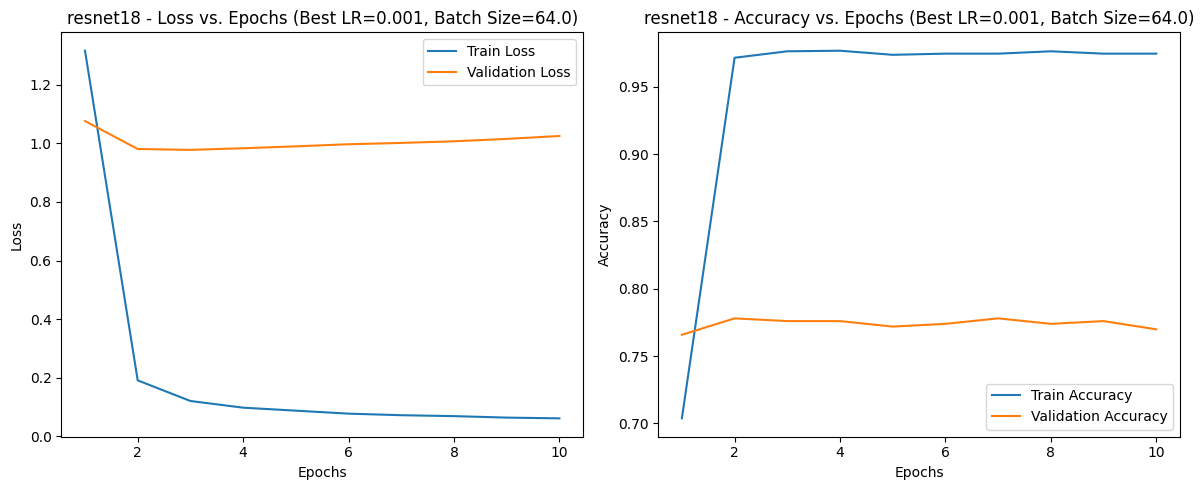

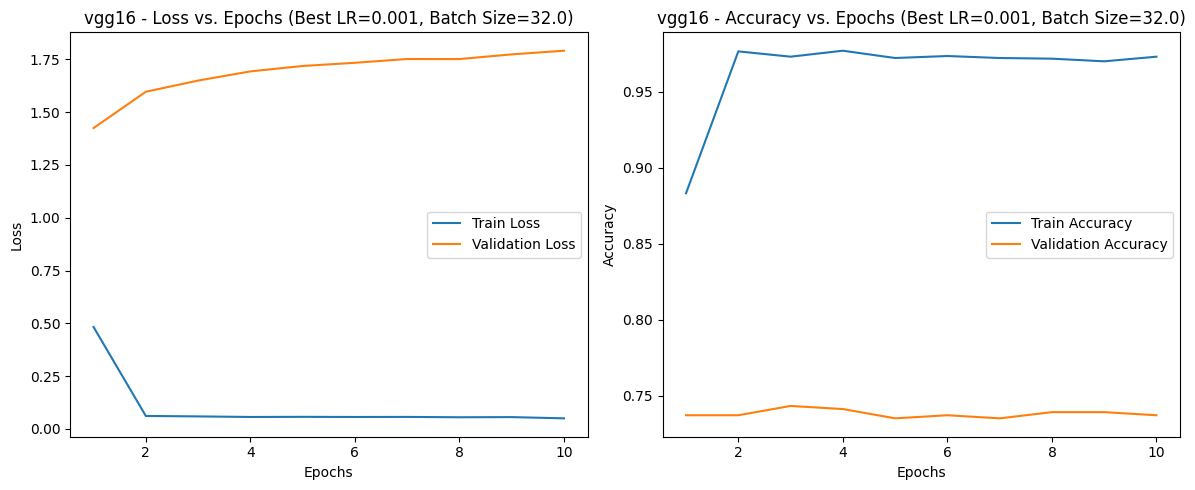

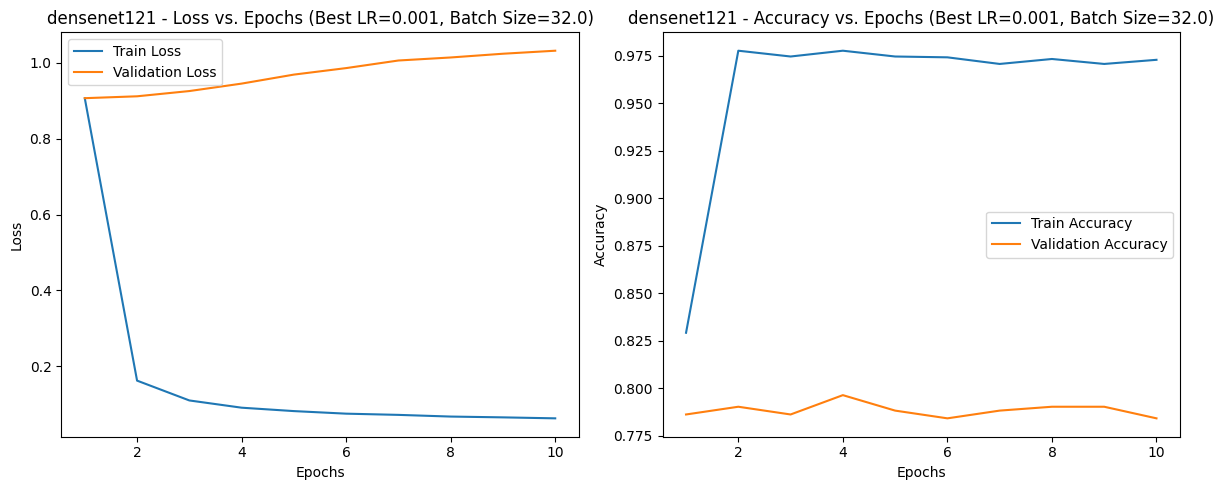

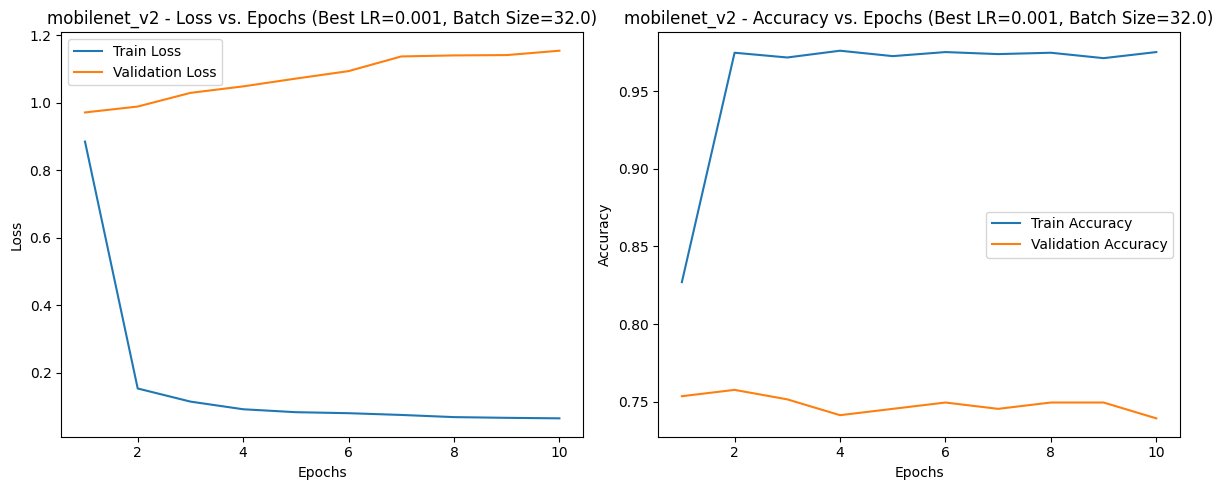

In [ ]:
plot_best_learning_curves('resnet18')
plot_best_learning_curves('vgg16')
plot_best_learning_curves('densenet121')
plot_best_learning_curves('mobilenet_v2')